In [1]:
import pandas as pd
import time
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession, types
import pyspark.sql.functions as F
from  pyspark.sql.functions import col

spark = (
    SparkSession.builder.config("spark.sql.debug.maxToStringFields", 100)
    .appName("reviews")
    .getOrCreate()
)

data_filepath = "../data/cleaned_steam_reviews"
steam_games_filepath = "../data/cleaned_steam_games"

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/24 16:39:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/11/24 16:39:30 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/11/24 16:39:30 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [2]:
steam_reviews = spark.read.parquet(data_filepath)

In [3]:
steam_games = spark.read.parquet(steam_games_filepath)

In [4]:
steam_reviews.printSchema()

root
 |-- app_id: string (nullable = true)
 |-- app_name: string (nullable = true)
 |-- review_id: string (nullable = true)
 |-- language: string (nullable = true)
 |-- review: string (nullable = true)
 |-- timestamp_created: string (nullable = true)
 |-- timestamp_updated: string (nullable = true)
 |-- recommended: boolean (nullable = true)
 |-- votes_helpful: integer (nullable = true)
 |-- votes_funny: integer (nullable = true)
 |-- weighted_vote_score: float (nullable = true)
 |-- comment_count: integer (nullable = true)
 |-- steam_purchase: boolean (nullable = true)
 |-- received_for_free: boolean (nullable = true)
 |-- written_during_early_access: boolean (nullable = true)
 |-- author_steamid: string (nullable = true)
 |-- author_num_games_owned: integer (nullable = true)
 |-- author_num_reviews: integer (nullable = true)
 |-- author_playtime_forever: float (nullable = true)
 |-- author_playtime_last_two_weeks: float (nullable = true)
 |-- author_playtime_at_review: float (nullabl

In [5]:
steam_games.printSchema()

root
 |-- url: string (nullable = true)
 |-- types: string (nullable = true)
 |-- name: string (nullable = true)
 |-- desc_snippet: string (nullable = true)
 |-- recent_reviews: string (nullable = true)
 |-- all_reviews: string (nullable = true)
 |-- release_date: date (nullable = true)
 |-- developer: string (nullable = true)
 |-- publisher: string (nullable = true)
 |-- popular_tags: string (nullable = true)
 |-- game_details: string (nullable = true)
 |-- languages: string (nullable = true)
 |-- achievements: integer (nullable = true)
 |-- genre: string (nullable = true)
 |-- game_description: string (nullable = true)
 |-- mature_content: string (nullable = true)
 |-- minimum_requirements: string (nullable = true)
 |-- recommended_requirements: string (nullable = true)
 |-- original_price: string (nullable = true)
 |-- discount_price: string (nullable = true)
 |-- game_id: string (nullable = true)



In [13]:
steam_reviews.show(10)

+------+--------------------+---------+--------+------------------------------------+-----------------+-----------------+-----------+-------------+-----------+-------------------+-------------+--------------+-----------------+---------------------------+-----------------+----------------------+------------------+-----------------------+------------------------------+-------------------------+------------------+-------+
|app_id|            app_name|review_id|language|                              review|timestamp_created|timestamp_updated|recommended|votes_helpful|votes_funny|weighted_vote_score|comment_count|steam_purchase|received_for_free|written_during_early_access|   author_steamid|author_num_games_owned|author_num_reviews|author_playtime_forever|author_playtime_last_two_weeks|author_playtime_at_review|author_last_played|game_id|
+------+--------------------+---------+--------+------------------------------------+-----------------+-----------------+-----------+-------------+-------

## Probability of recommended by language

In [42]:
recommended = steam_reviews.select("language", "recommended") \
                            .withColumn("recommended", col("recommended").cast("int")) \
                            .where(col("recommended").isNotNull()) \
                            .groupBy("language") \
                            .agg(F.avg("recommended").alias("recommended_prob")) \
                            .orderBy("recommended_prob", ascending=False)

In [43]:
recommended.show()

+----------+------------------+
|  language|  recommended_prob|
+----------+------------------+
|  romanian|0.9582124201973302|
|     latam|0.9520611968485913|
|portuguese|0.9520108859993952|
|    polish|0.9505445411855808|
| brazilian|0.9500624863500692|
|   spanish|0.9365137679723239|
|     czech|0.9337594256301164|
|   swedish|0.9331786473007789|
| hungarian|0.9314001372683597|
| ukrainian|0.9310029282576867|
|     dutch| 0.929525534461011|
|vietnamese|0.9278688524590164|
|    danish|0.9268829149077983|
|    french|0.9256060004230009|
| norwegian|0.9238913760988203|
|   finnish|0.9229994643813605|
|     greek|0.9218472468916519|
|      thai|0.9152453373266691|
|   italian|0.9137784914581382|
|    german| 0.908926752922741|
+----------+------------------+
only showing top 20 rows



<AxesSubplot:title={'center':'Probability of recommended by language'}, xlabel='Language', ylabel='Probability of recommended'>

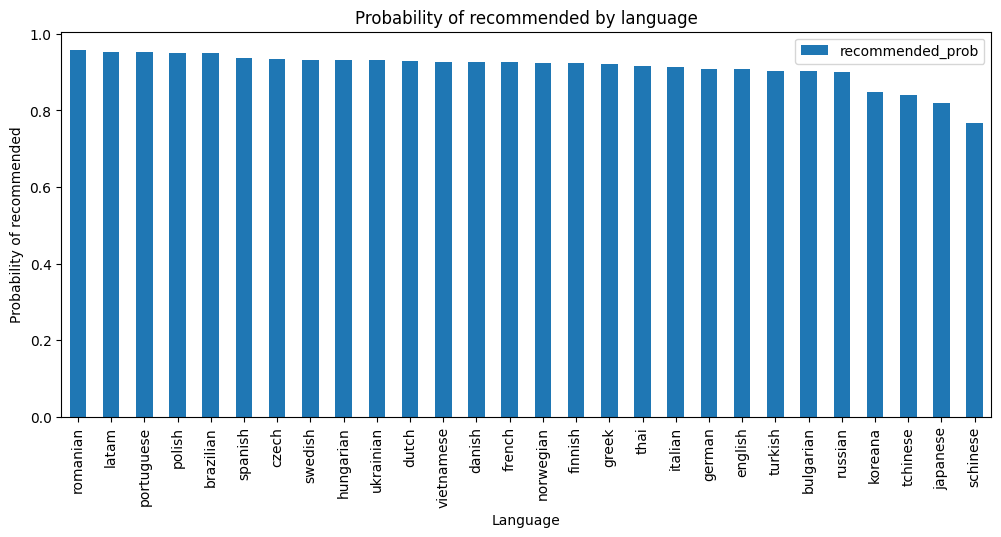

In [51]:
recommended.toPandas().plot.bar(x="language",
                                y="recommended_prob", figsize=(12, 5),
                                title="Probability of recommended by language",
                                xlabel = "Language",
                                ylabel = "Probability of recommended")

## Statistics by language

In [3]:
stats_by_language = steam_reviews.select("language", "recommended", "received_for_free", "author_num_games_owned", "author_playtime_forever", "author_playtime_at_review") \
                                .withColumn("recommended", col("recommended").cast("int")) \
                                .withColumn("received_for_free", col("received_for_free").cast("int")) \
                                .where(col("recommended").isNotNull() & col("received_for_free").isNotNull() & col("author_num_games_owned").isNotNull() & col("author_playtime_forever").isNotNull() & col("author_playtime_at_review").isNotNull()) \
                                .groupBy("language") \
                                .agg( \
                                        F.avg("recommended").alias("recommended_prob"), \
                                        F.avg("received_for_free").alias("received_for_free_prob"), \
                                        F.avg("author_num_games_owned").alias("author_num_games_owned_avg"), \
                                        F.avg("author_playtime_forever").alias("author_playtime_forever_avg"), \
                                        F.avg("author_playtime_at_review").alias("author_playtime_at_review_avg") \
                                    ) \
                                .orderBy("recommended_prob", ascending=False)

In [4]:
stats_by_language.show()

+----------+------------------+----------------------+--------------------------+---------------------------+-----------------------------+
|  language|  recommended_prob|received_for_free_prob|author_num_games_owned_avg|author_playtime_forever_avg|author_playtime_at_review_avg|
+----------+------------------+----------------------+--------------------------+---------------------------+-----------------------------+
|  romanian|0.9581682718517173|   0.10986734508449936|         62.42409594766491|         14485.833981464655|            6388.721606396511|
|     latam| 0.952068386505877|   0.03600595328957411|        119.65022515646466|          10865.81115478553|            6341.518394138299|
|portuguese|0.9520650642918806|  0.058491223287443016|          82.4140124494525|          17340.90652308904|              8644.8450936738|
|    polish|0.9505781531391666|   0.04132149288952369|          90.0342023225486|         11938.582343662672|             6441.90535676582|
| brazilian|0.950112

<AxesSubplot:title={'center':'Average Playtime by language'}, xlabel='Language', ylabel='Average Playtime (minutes)'>

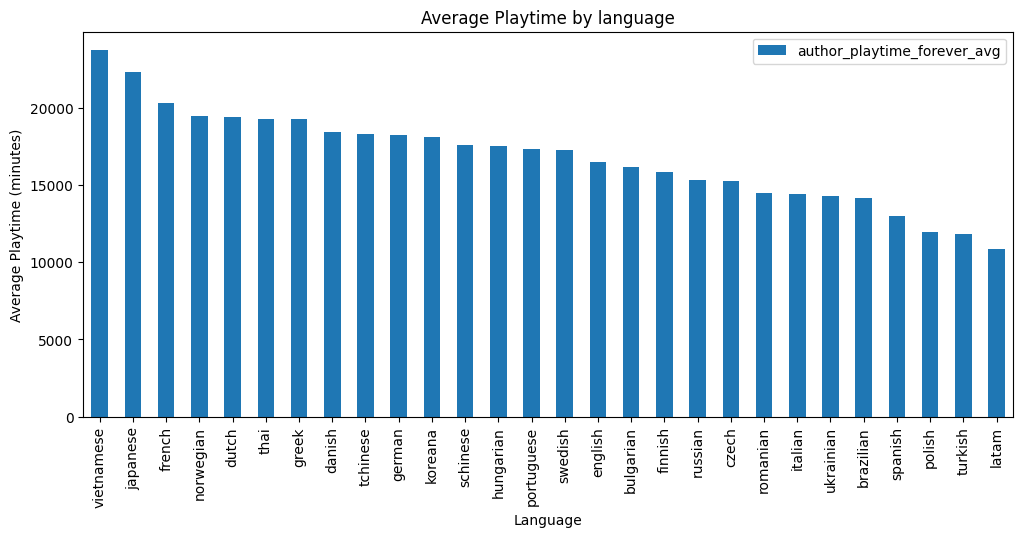

In [10]:
author_playtime_forever_avg = stats_by_language.select("language", "author_playtime_forever_avg").orderBy("author_playtime_forever_avg", ascending=False)
author_playtime_forever_avg.toPandas().plot.bar(x="language",
                                                y="author_playtime_forever_avg", figsize=(12, 5),
                                                title="Average Playtime by language",
                                                xlabel = "Language",
                                                ylabel = "Average Playtime (minutes)")

<AxesSubplot:title={'center':'Average Number of Games Owned by language'}, xlabel='Language', ylabel='Average Number of Games Owned'>

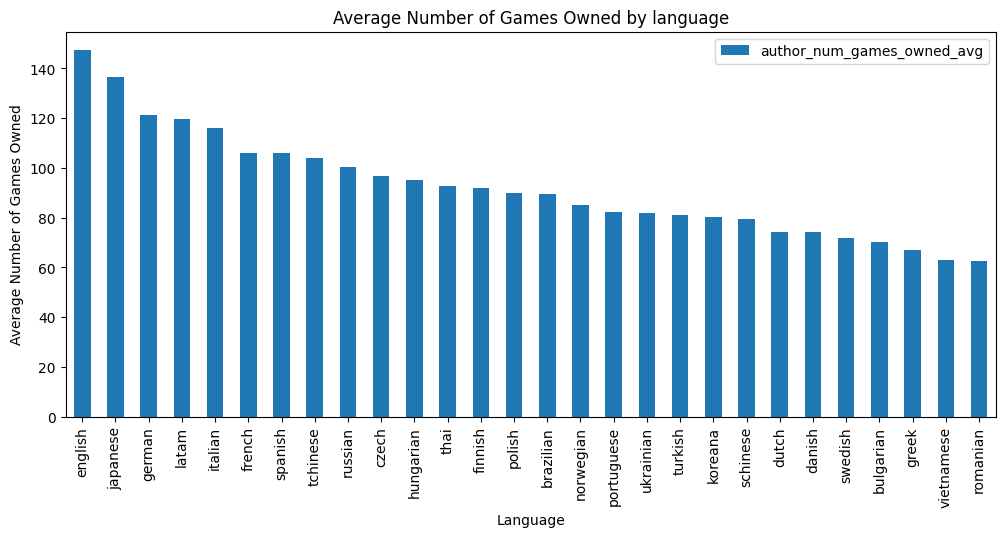

In [13]:
author_num_games_owned_avg = stats_by_language.select("language", "author_num_games_owned_avg").orderBy("author_num_games_owned_avg", ascending=False)
author_num_games_owned_avg.toPandas().plot.bar(x="language",
                                                y="author_num_games_owned_avg", figsize=(12, 5),
                                                title="Average Number of Games Owned by language",
                                                xlabel = "Language",
                                                ylabel = "Average Number of Games Owned")

<AxesSubplot:title={'center':'Average Playtime at Review by language'}, xlabel='Language', ylabel='Average Playtime at Review (minutes)'>

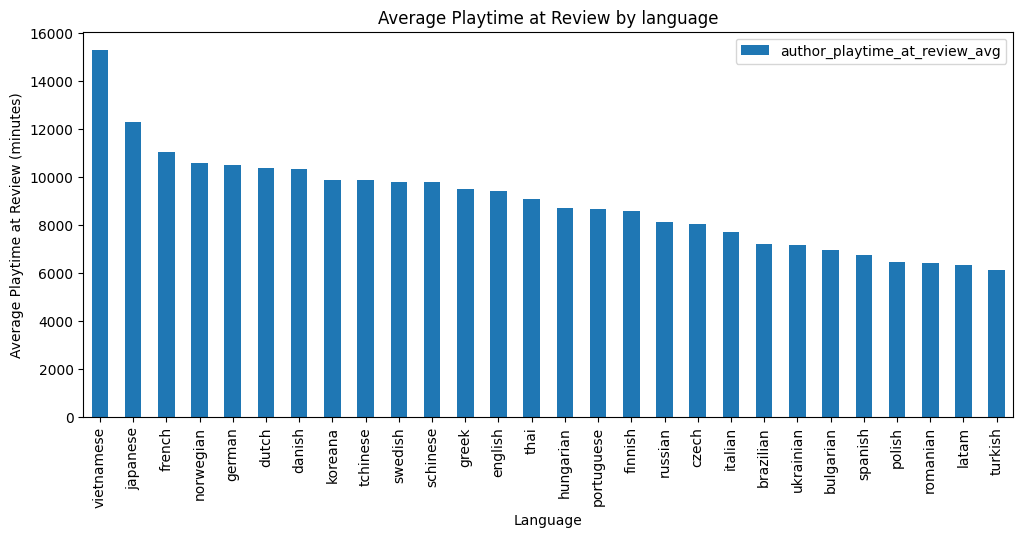

In [12]:
author_playtime_at_review_avg = stats_by_language.select("language", "author_playtime_at_review_avg").orderBy("author_playtime_at_review_avg", ascending=False)
author_playtime_at_review_avg.toPandas().plot.bar(x="language",
                                                    y="author_playtime_at_review_avg", figsize=(12, 5),
                                                    title="Average Playtime at Review by language",
                                                    xlabel = "Language",
                                                    ylabel = "Average Playtime at Review (minutes)")

<AxesSubplot:title={'center':'Received for Free Probability by language'}, xlabel='Language', ylabel='Received for Free'>

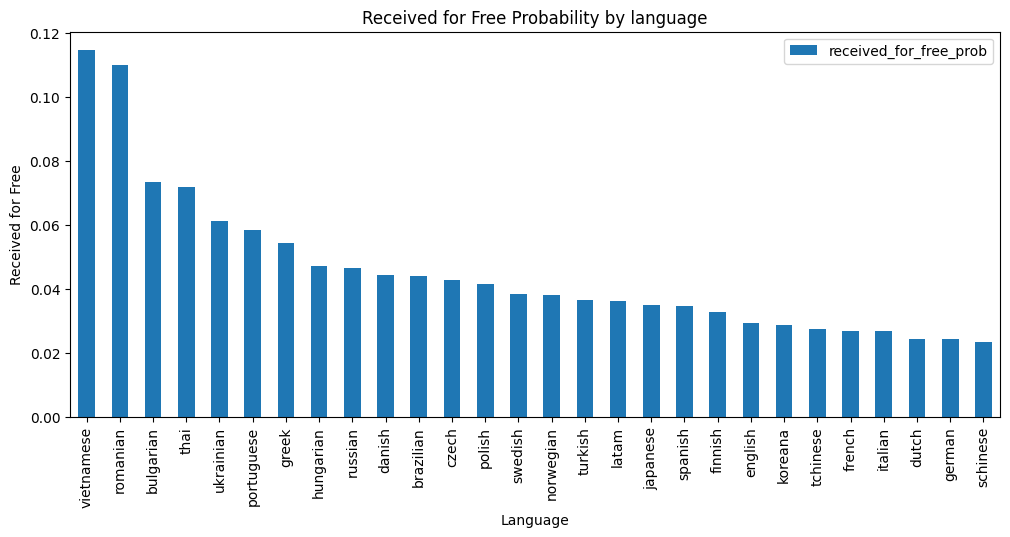

In [15]:
received_for_free_prob = stats_by_language.select("language", "received_for_free_prob").orderBy("received_for_free_prob", ascending=False)
received_for_free_prob.toPandas().plot.bar(x="language",
                                            y="received_for_free_prob", figsize=(12, 5),
                                            title="Received for Free Probability by language",
                                            xlabel = "Language",
                                            ylabel = "Received for Free")

# Regional difference of each Game Tags

In [14]:
tags_map = steam_games.select("game_id", F.explode_outer(F.split(col("popular_tags"),",")).alias("tags")) \
                        .drop("popular_tags") \
                        .where(col("tags") != F.lit("null"))

top_20_tags = tags_map.groupBy("tags") \
                        .count() \
                        .orderBy("count", ascending=False) \
                        .limit(20) \
                        .select("tags") \
                        .distinct() \
                        .orderBy("tags")

top_20_tags_names = map(lambda row: row.asDict(), top_20_tags.collect())
top_20_tags_names = [row["tags"] for row in top_20_tags_names]

tags = tags_map.join(top_20_tags, "tags").select("game_id", tags_map["tags"]).distinct()


languages = steam_reviews.select("language").groupBy("language").agg(F.count("language").alias("count")).where(col("count") > 100).orderBy("language")
languages_names = map(lambda row: row.asDict(), languages.collect())
languages_names = [row["language"] for row in languages_names]

language_pos = {}
tags_pos = {}
for pos, language in enumerate(languages_names):
    language_pos[language] = pos
for pos, tag in enumerate(top_20_tags_names):
    tags_pos[tag] = pos

## Regional difference of Recommended Probability for each game tag

In [21]:
recommended_regional = steam_reviews.select("app_id", "language", "recommended") \
                                    .withColumn("recommended", col("recommended").cast("int")) \
                                    .where(col("recommended").isNotNull())


recommended_regional_by_genre = recommended_regional.join(tags, recommended_regional["app_id"] == tags["game_id"]).drop("game_id")

recommended_regional_by_genre = recommended_regional_by_genre.groupBy("language", "tags") \
                                                                .agg(F.avg("recommended").alias("recommended_prob")) \
                                                                .orderBy("recommended_prob", ascending=False)


recommended_regional_by_genre_dict = list(map(lambda row: row.asDict(), recommended_regional_by_genre.collect()))

matrix = [ [0] * len(top_20_tags_names) for _ in range(len(languages_names)) ]

for data in recommended_regional_by_genre_dict:
    language = data["language"]
    tag = data["tags"]
    prob = data["recommended_prob"]
    matrix[language_pos[language]][tags_pos[tag]] = prob


for i in range(len(matrix)):
    for j in range(len(matrix[0])):
        matrix[i][j] = round(matrix[i][j] * 100, 2)

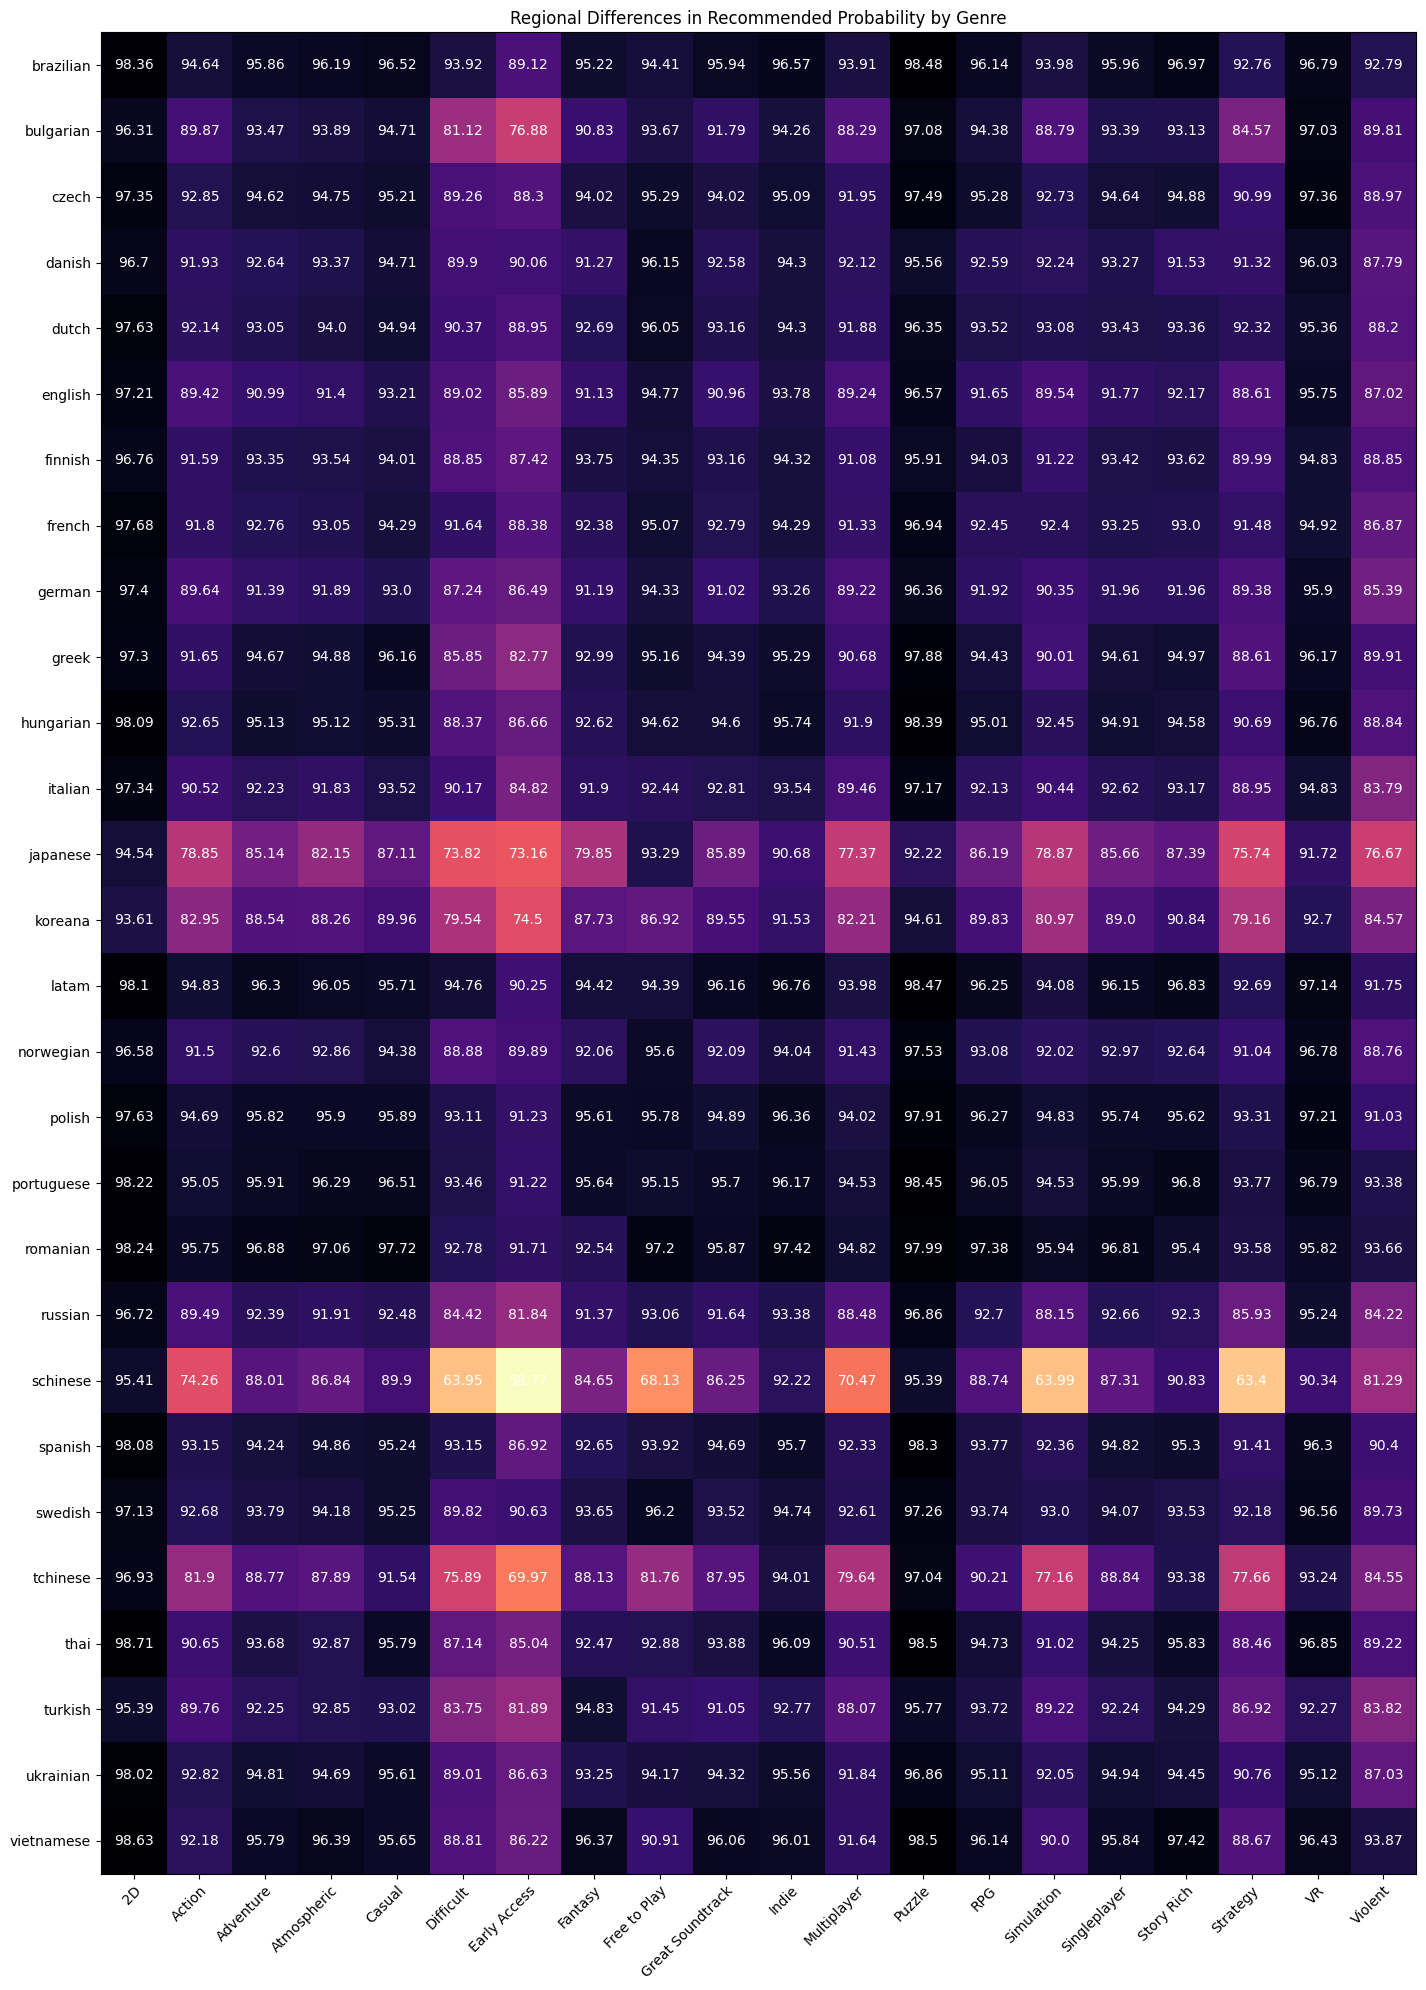

In [22]:
H = len(top_20_tags_names)
W = len(languages_names)


from matplotlib.pyplot import plot
import numpy as np

matrix_np = np.array(matrix)

fig, ax = plt.subplots(figsize=(30, 20))
im = ax.imshow(matrix_np, cmap="magma_r")

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(top_20_tags_names)), labels=top_20_tags_names)
ax.set_yticks(np.arange(len(languages_names)), labels=languages_names)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(languages_names)):
    for j in range(len(top_20_tags_names)):
        text = ax.text(j, i, matrix_np[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Regional Differences in Recommended Probability by Genre")
fig.tight_layout()
plt.show()

## Regional difference for each game tag on Probability of Received For Free (Not really that useful)

In [16]:
languages_names_no_english = languages_names.copy()
# languages_names_no_english.remove("english")

language_no_eng_pos = {}
for pos, language in enumerate(languages_names_no_english):
    language_no_eng_pos[language] = pos

count_regional = steam_reviews.select("app_id", "language", "received_for_free").where(col("received_for_free").isNotNull()).withColumn("received_for_free", col("received_for_free").cast("int"))


count_regional_by_genre = count_regional.join(tags, count_regional["app_id"] == tags["game_id"]).drop("game_id")

count_regional_by_genre = count_regional_by_genre.groupBy("language", "tags") \
                                                .agg(F.avg("received_for_free").alias("playtime")) \
                                                .orderBy("playtime", ascending=False)


count_regional_by_genre_dict = list(map(lambda row: row.asDict(), count_regional_by_genre.collect()))

matrix = [ [0] * len(top_20_tags_names) for _ in range(len(languages_names_no_english)) ]

for data in count_regional_by_genre_dict:
    if (data["language"] not in languages_names_no_english):
        continue
    language = data["language"]
    tag = data["tags"]
    count = data["playtime"]
    matrix[language_no_eng_pos[language]][tags_pos[tag]] = count


for i in range(len(matrix)):
    for j in range(len(matrix[0])):
        matrix[i][j] = round(matrix[i][j] * 100, 2)

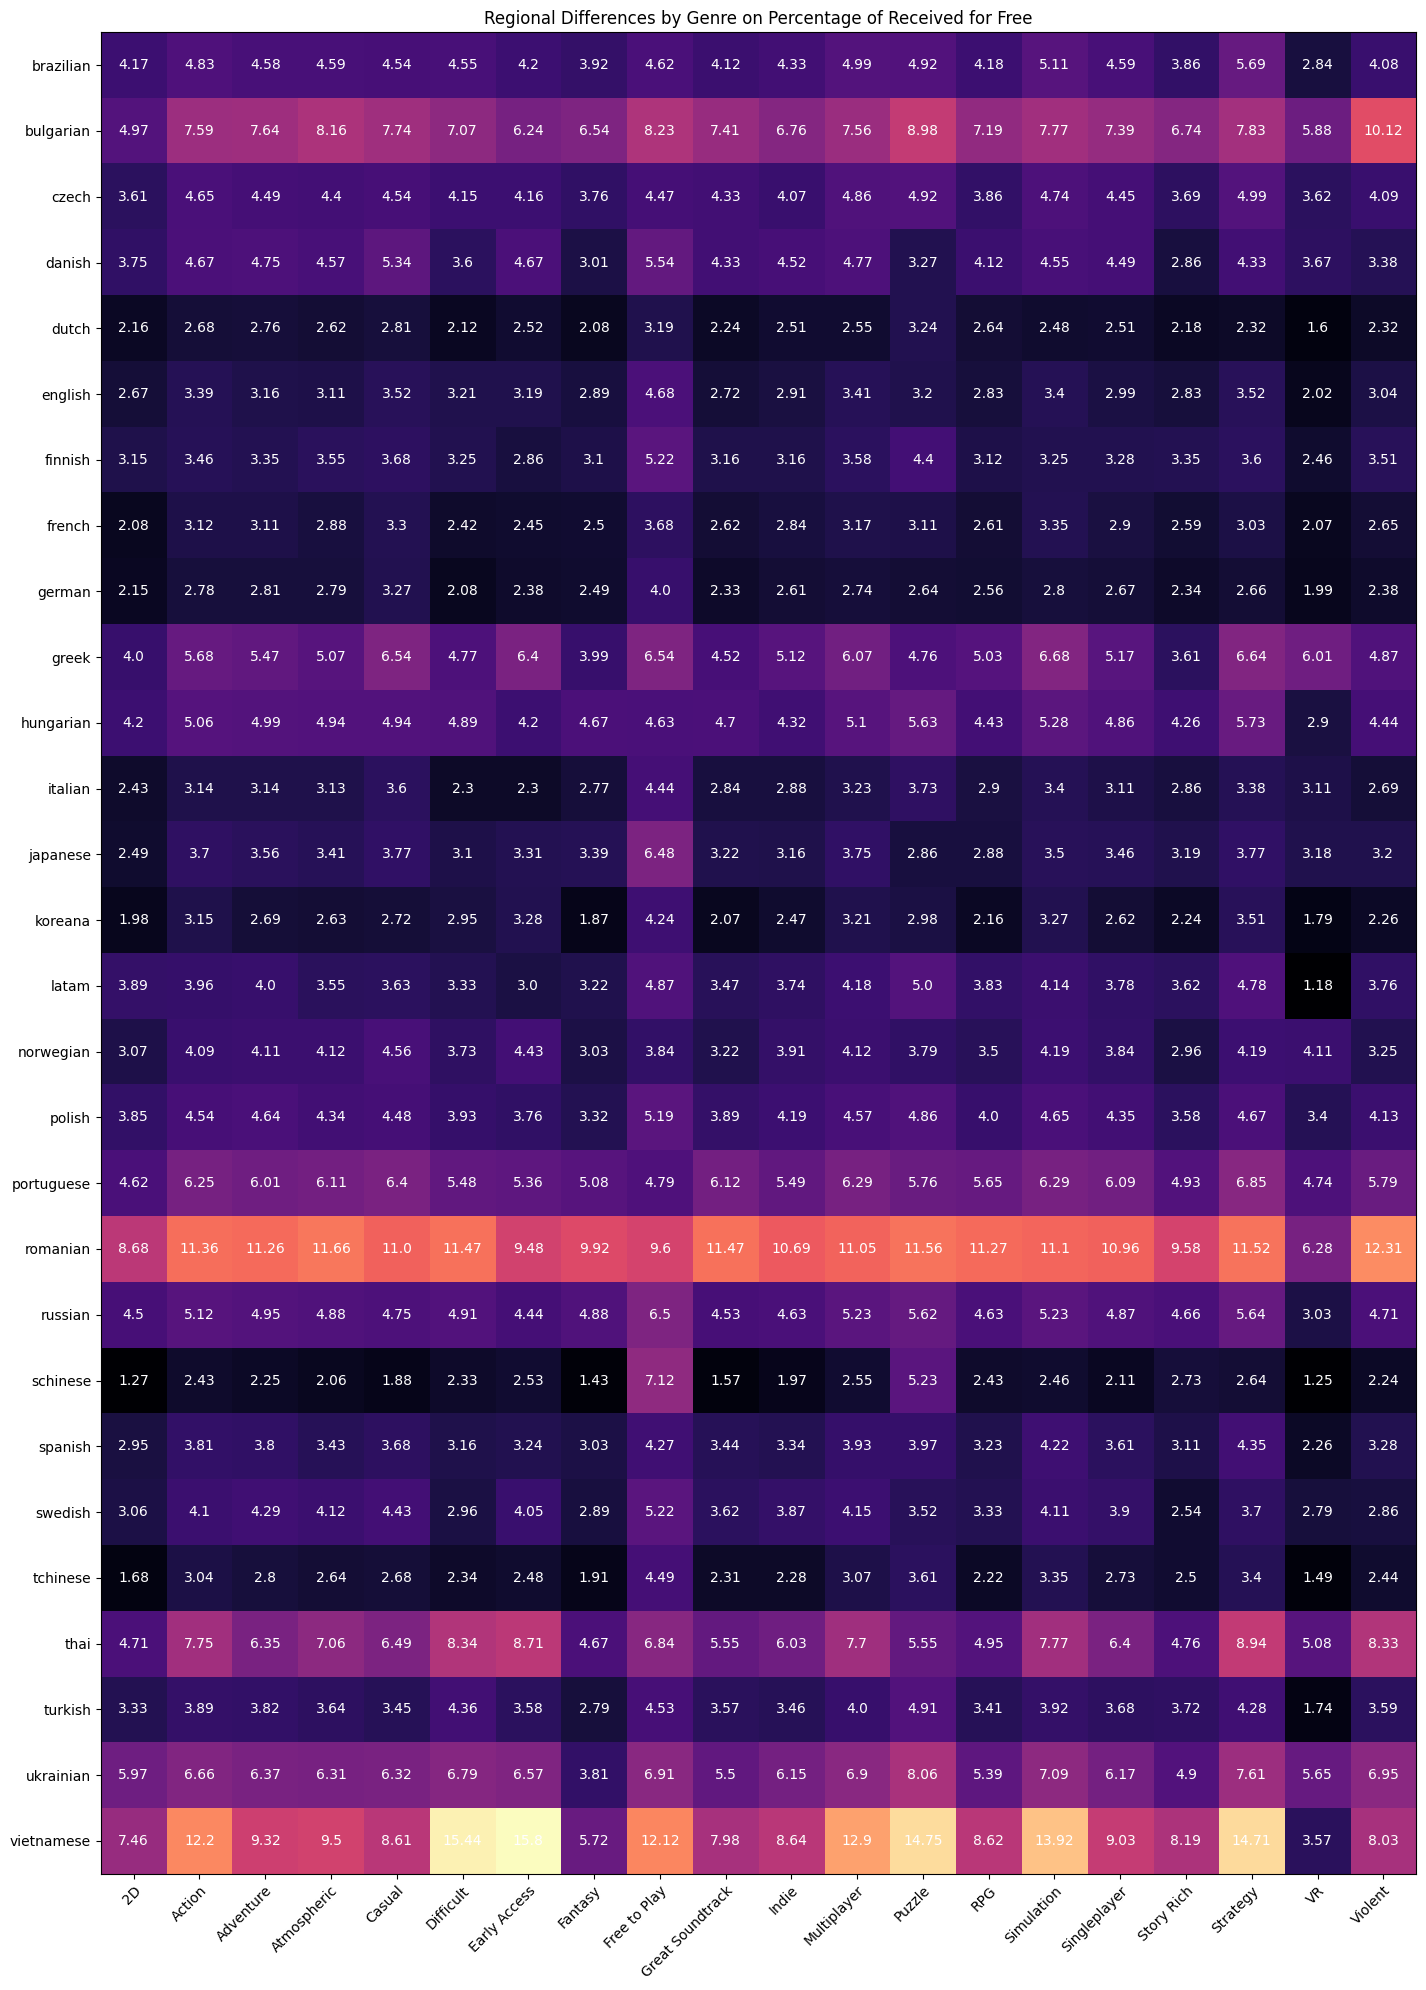

In [18]:
H = len(top_20_tags_names)
W = len(languages_names_no_english)

from matplotlib.pyplot import plot
import numpy as np

matrix_np = np.array(matrix)

fig, ax = plt.subplots(figsize=(30, 20))
im = ax.imshow(matrix_np, cmap="magma")

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(top_20_tags_names)), labels=top_20_tags_names)
ax.set_yticks(np.arange(len(languages_names_no_english)), labels=languages_names_no_english)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(languages_names_no_english)):
    for j in range(len(top_20_tags_names)):
        text = ax.text(j, i, matrix_np[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Regional Differences by Genre on Percentage of Received for Free")
fig.tight_layout()
plt.show()

## Regional difference for each game tag on Average number of Games Owned (Not really that useful)

In [19]:
languages_names_no_english = languages_names.copy()
# languages_names_no_english.remove("english")

language_no_eng_pos = {}
for pos, language in enumerate(languages_names_no_english):
    language_no_eng_pos[language] = pos

count_regional = steam_reviews.select("app_id", "language", "author_num_games_owned")


count_regional_by_genre = count_regional.join(tags, count_regional["app_id"] == tags["game_id"]).drop("game_id")

count_regional_by_genre = count_regional_by_genre.groupBy("language", "tags") \
                                                .agg(F.avg("author_num_games_owned").alias("playtime")) \
                                                .orderBy("playtime", ascending=False)


count_regional_by_genre_dict = list(map(lambda row: row.asDict(), count_regional_by_genre.collect()))

matrix = [ [0] * len(top_20_tags_names) for _ in range(len(languages_names_no_english)) ]

for data in count_regional_by_genre_dict:
    if (data["language"] not in languages_names_no_english):
        continue
    language = data["language"]
    tag = data["tags"]
    count = data["playtime"]
    matrix[language_no_eng_pos[language]][tags_pos[tag]] = count


for i in range(len(matrix)):
    for j in range(len(matrix[0])):
        matrix[i][j] = round(matrix[i][j] * 100, 2)

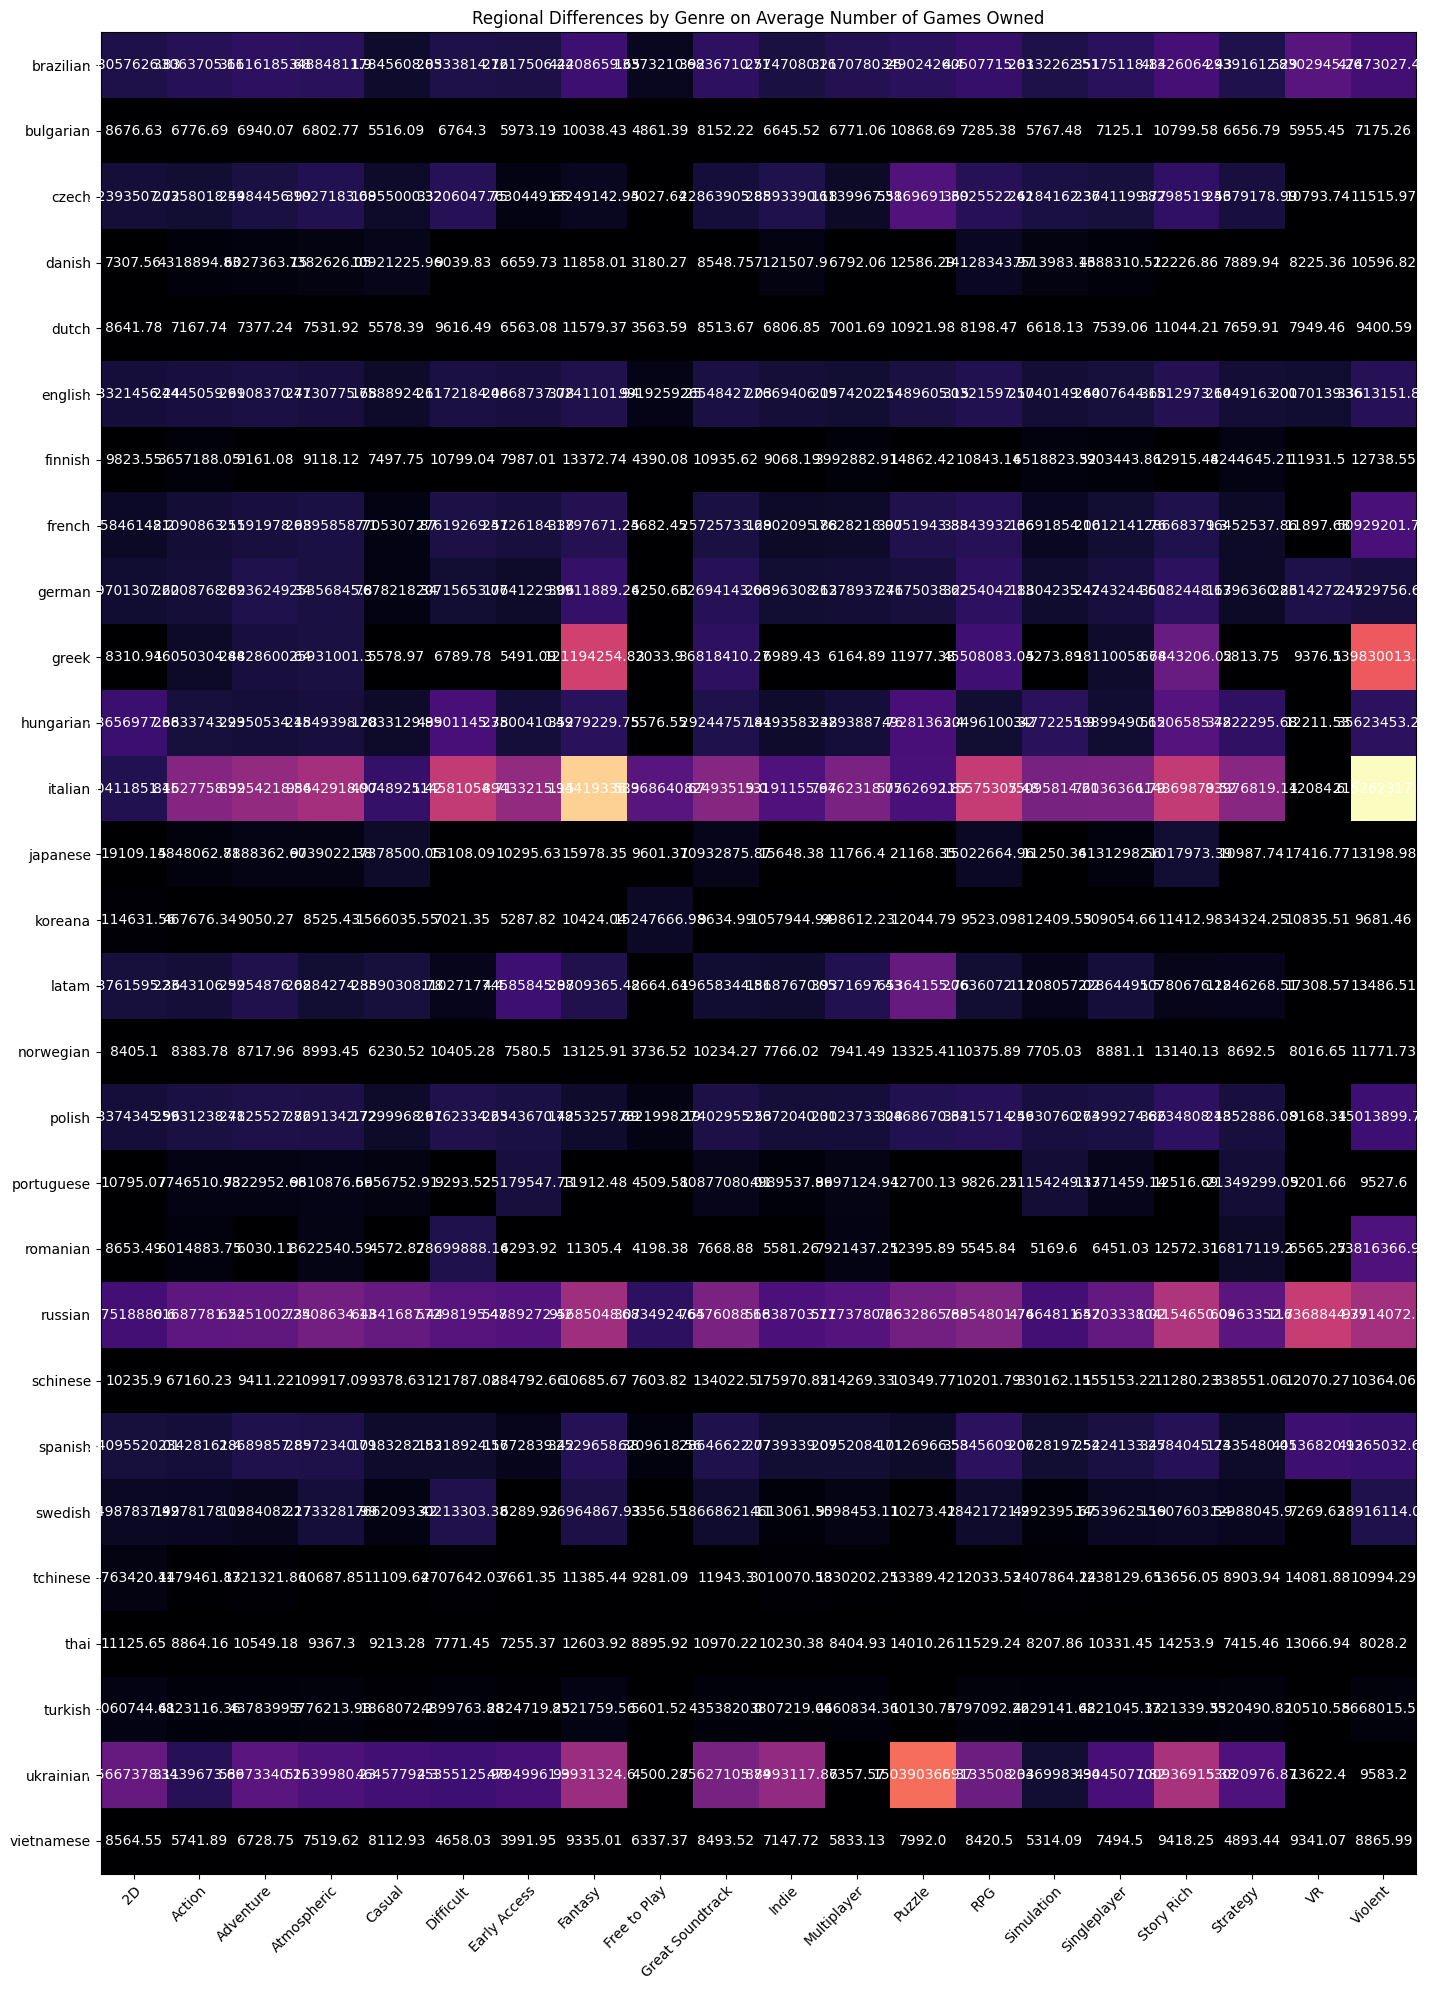

In [20]:
H = len(top_20_tags_names)
W = len(languages_names_no_english)

from matplotlib.pyplot import plot
import numpy as np

matrix_np = np.array(matrix)

fig, ax = plt.subplots(figsize=(30, 20))
im = ax.imshow(matrix_np, cmap="magma")

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(top_20_tags_names)), labels=top_20_tags_names)
ax.set_yticks(np.arange(len(languages_names_no_english)), labels=languages_names_no_english)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(languages_names_no_english)):
    for j in range(len(top_20_tags_names)):
        text = ax.text(j, i, matrix_np[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Regional Differences by Genre on Average Number of Games Owned")
fig.tight_layout()
plt.show()

# Language Count

In [55]:
languages = steam_reviews.groupBy("language").count().where(col("count") > 1000).sort(col("count").desc())

In [14]:
languages.show(30)

+----------+-------+
|  language|  count|
+----------+-------+
|   english|9635376|
|  schinese|3764936|
|   russian|2348872|
| brazilian| 837515|
|   spanish| 813308|
|    german| 752587|
|   turkish| 635851|
|   koreana| 613632|
|    french| 541745|
|    polish| 495514|
|  tchinese| 218202|
|     czech| 133979|
|   italian| 133307|
|      thai| 127503|
|  japanese|  81753|
|portuguese|  81385|
|   swedish|  80225|
|     dutch|  77555|
| hungarian|  71000|
|     latam|  70103|
|    danish|  55914|
|   finnish|  54711|
| norwegian|  36797|
|  romanian|  32727|
| ukrainian|  21168|
|     greek|  14472|
| bulgarian|  10454|
|vietnamese|   6580|
+----------+-------+



In [15]:
languages.count()

28